In [10]:
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
# from IPython.display import display, HTML

from pykat import finesse                  
from pykat.commands import *              


pykat.init_pykat_plotting(dpi=90)

In [3]:
# base model on which to make changes
basekat = finesse.kat()
basekat.verbose = False

In [4]:
basecode = """
l laser 1 0 n0   # Laser (Power = 1 W, wavelength offset = 0)
s s1 1 n0 nc1    # Space (Length = 1 m)

# the cavity
m m1 0.7 0.3 0 nc1 nc2  # Mirror  (R = 0.7, T = 0.3, phi = 0)
s sL 4000 nc2 nc3       # Space (Length = 4 km)
m m2 0.8 0.2 0 nc3 nc4  # Mirror  (R = 0.8, T = 0.2, phi = 0)

# detectors
pd circ nc2
pd tran nc4
pd refl nc1
"""

basekat.parse(basecode)

In [5]:
print(basekat.components,basekat.detectors,basekat.commands,sep='\n')

{'laser': <pykat.components.laser_1 (laser) at 0x7f219e740f98>, 's1': <pykat.components.space_2 (s1) at 0x7f21d02173c8>, 'm1': <pykat.components.mirror_3 (m1) at 0x7f219e74a2b0>, 'sL': <pykat.components.space_4 (sL) at 0x7f219e74ab00>, 'm2': <pykat.components.mirror_5 (m2) at 0x7f219e74aeb8>}
{'circ': <pykat.detectors.pykat.detectors.pd_1 object at 0x7f219e758668>, 'tran': <pykat.detectors.pykat.detectors.pd_2 object at 0x7f219e7589b0>, 'refl': <pykat.detectors.pykat.detectors.pd_3 object at 0x7f219e758cf8>}
{}


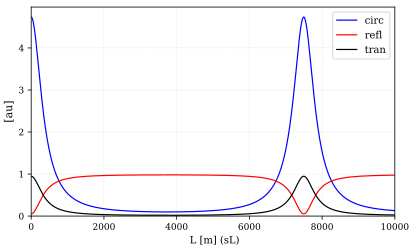

In [28]:
# laser offset frequency
kat1 = deepcopy(basekat)
kat1.laser.f = 2e4
kat1code = """
xaxis sL L lin 0 10k 2000
# yaxis abs
"""

kat1.parse(kat1code)
out1 = kat1.run()
out1.plot(ylim=(0,None))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: UserWarning: parseKatCode depreciated, use parse.


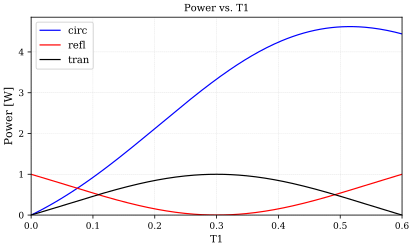

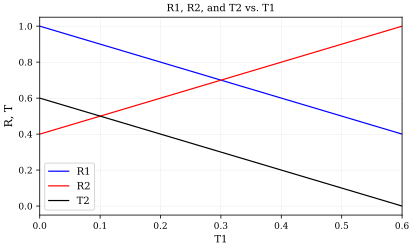

In [30]:
# changing T1, fixing T1 + T2
kat1 = deepcopy(basekat)

code = """
## Simulation instructions ##
xaxis m1 T lin 0 0.6 200   # Varying transmittance of input mirror m1.
yaxis abs                  # Plotting the amplitude of the detector measurements. 

## Functions computing reflectance and transmittance ##
func R1 = 1-$x1             # Reflectance of m1 (lossless)
func T2 = 0.6 - $x1         # Transmittance of m2 (T1 + T2 = 0.6)
func R2 = 1-$T2             # Reflectance of m2

## Setting values ## 
put m1 R $R1                # Setting reflectance of m1 to R1
put m2 T $T2                # Setting transmittance of m2 to T2
put m2 R $R2                # Setting reflectance of m2 to R2
"""

kat1.parseKatCode(code) # Parsing the FINESSE-code
out1 = kat1.run() 

fig1a = out1.plot(detectors=['refl','circ','tran'], 
                  xlabel='T1', 
                  ylabel='Power [W]', 
                  title = 'Power vs. T1',
                  ylim = (0,None))

# Reflectances and transmittances
fig1b = out1.plot(detectors=['R1','R2','T2'], 
                  xlabel='T1', 
                  ylabel='R, T', title='R1, R2, and T2 vs. T1')

In [40]:
kat2 = deepcopy(basekat)

code = """
ad a_refl 0 nc1
ad a_tran 0 nc4
ad a_circ 0 nc2

xaxis m2 phi lin -180 180 2000
yaxis abs:deg
"""

kat2.parse(code)

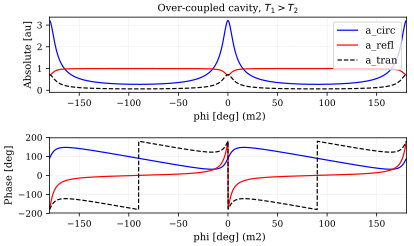

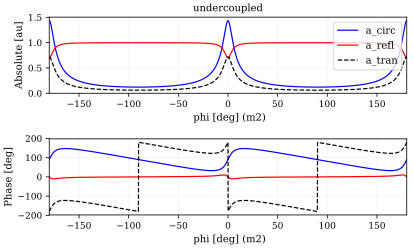

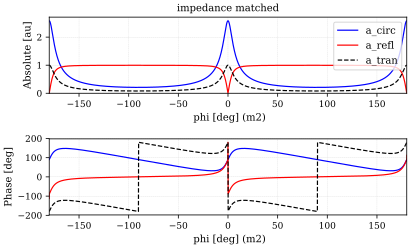

In [55]:
T_tot = 0.3

# Over-coupled, T1 > T2
T1 = 0.25
T2 = T_tot-T1
R1 = 1-T1
R2 = 1-T2
kat2.m1.T = T1
kat2.m1.R = R1
kat2.m2.T = T2
kat2.m2.R = R2
out2a = kat2.run()

# Under-coupled, T1 < T2
T1 = 0.05
T2 = T_tot-T1
R1 = 1-T1
R2 = 1-T2
kat2.m1.T = T1
kat2.m1.R = R1
kat2.m2.T = T2
kat2.m2.R = R2
out2b = kat2.run()

# Impedance matched, T1 = T2
T1 = 0.15
T2 = T_tot-T1
R1 = 1-T1
R2 = 1-T2
kat2.m1.T = T1
kat2.m1.R = R1
kat2.m2.T = T2
kat2.m2.R = R2
out2c = kat2.run() 

fig2a = out2a.plot(detectors=['a_circ','a_refl','a_tran'],
                   title = 'Over-coupled cavity, $T_1>T_2$',
                   styles={'a_circ':'b-','a_refl':'r-','a_tran':'k--'})

fig2b = out2b.plot(detectors=['a_circ','a_refl','a_tran'],
                  ylim = (0,None),
                  styles = {'a_circ':'b-','a_refl':'r-','a_tran':'k--'},
                  title = 'undercoupled')
fig2c = out2c.plot(detectors=['a_circ','a_refl','a_tran'],
                  ylim = (0,None),
                  styles = {'a_circ':'b-','a_refl':'r-','a_tran':'k--'},
                  title = 'impedance matched')

In [56]:
kat3 = deepcopy(basekat)
code = """
xaxis laser f lin -5k 90k 1000
yaxis abs
"""
kat3.parse(code)

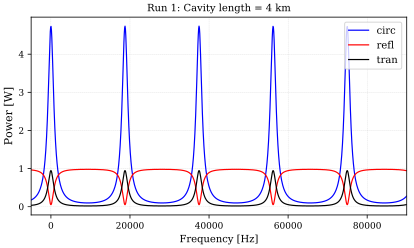

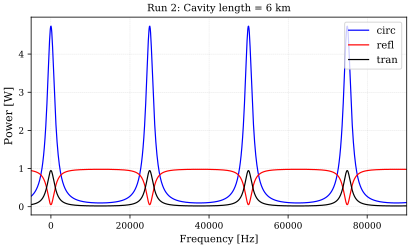

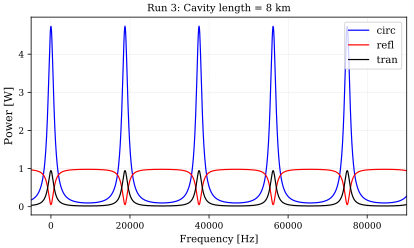

In [59]:
# 1st run, original cavity length of 4 km.
out3a = kat3.run()

# 2nd run, cavity length of 6 km.
kat3.sL.L = 6000
out3b = kat3.run()

# 3rd run, cavity length of 8 km.
kat3.sL.L = 8000
out3c = kat3.run()

# Run 1
fig3a = out3a.plot(xlabel='Frequency [Hz]', 
                   ylabel='Power [W]', 
                   title='Run 1: Cavity length = 4 km',
                   loc=1)
# Run 2
fig3b = out3b.plot(xlabel='Frequency [Hz]', 
                   ylabel='Power [W]', 
                   title='Run 2: Cavity length = 6 km', 
                   loc=1)
# Run 3
fig3c = out3c.plot(xlabel='Frequency [Hz]', 
                   ylabel='Power [W]', 
                   title='Run 3: Cavity length = 8 km', 
                   loc = 1)

In [ ]:
# ignoring optimisation task because it looks pretty tedious

In [90]:
ifobasekat = finesse.kat()

code = """
## Parameters ##
const Pin 1M         # Laser power (1 MW)
const LX 4000        # Length of X arm (4000 m)
const LY 4000        # Length of Y arm (4000 m)

## Laser & Beam splitter ##
l laser $Pin 0 n0                         # Laser
s s1 1 n0 nbsc                            # Space from laser to beam splitter
bs BS 0.5 0.5 0 45 nbsc nbsY nbsX nbsd    # Beam splitter (R = T = 0.5, phi = 0 deg, 
                                          # AoI = 45 deg).
## X arm ##
s LX $LX nbsX nmX1         # Space, BS to mX (4000 m)
m mX 1 0 0 nmX1 nmX2       # Mirror mX (R = 1, T = 0, phi = 0 deg)

## Y arm ##
s LY $LY nbsY nmY1         # Space, BS to mY (4000 m)
m mY 1 0 0 nmY1 nmY2       # Mirror mY (R = 1, T = 0, phi = 0 deg)

## Output port ##
s sout 1 nbsd nout         # Space, BS to output
pd pout nout

"""
# """
# # constants
# const Pin 1M
# const LX 4k
# const LY 4k

# # components
# l laser Pin 0 n1
# s s1 1 n1 nbs1
# bs BS 0.5 0.5 0 45 nbs1 nbs2 nbs3 nbs4
# s sx LX nbs2 nm1
# m m1 0.9 0.1 0 nm1 nm1o
# s sy LY nbs3 nm2
# m m2 0.9 0.1 0 nm2 nm2o

# # detectors
# pd darkport nbs4
# pd brightport nbs1
# """

ifobasekat.parse(code)

In [92]:
print(ifobasekat.components,ifobasekat.detectors,ifobasekat.constants,sep='\n')

{'laser': <pykat.components.laser_387 (laser) at 0x7f219c093390>, 's1': <pykat.components.space_388 (s1) at 0x7f219e68a5f8>, 'BS': <pykat.components.beamSplitter_389 (BS) at 0x7f219c122c18>, 'LX': <pykat.components.space_390 (LX) at 0x7f219e68a0f0>, 'mX': <pykat.components.mirror_391 (mX) at 0x7f219e70d0b8>, 'LY': <pykat.components.space_392 (LY) at 0x7f219c0ff518>, 'mY': <pykat.components.mirror_393 (mY) at 0x7f219c0ff438>, 'sout': <pykat.components.space_394 (sout) at 0x7f219c5b5ac8>}
{'pout': <pykat.detectors.pykat.detectors.pd_216 object at 0x7f219c5b5710>}
{}


In [116]:
# differential tuning
kat1 = deepcopy(ifobasekat)
code = """
xaxis mX phi lin -180 180 2000
put* mY phi $mx1
yaxis abs
"""
kat1.parse(code)

--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:38:29.669371
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0653167 seconds


100% | ETA:  0:00:00 | Calculating                                             

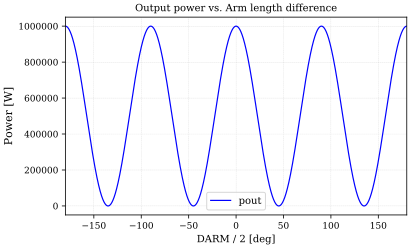

In [117]:
out1 = kat1.run()

fig1 = out1.plot(xlabel="DARM / 2 [deg]", 
                 ylabel="Power [W]", 
                 title="Output power vs. Arm length difference")

--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:38:31.784579
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0609529 seconds


100% | ETA:  0:00:00 | Calculating                                             

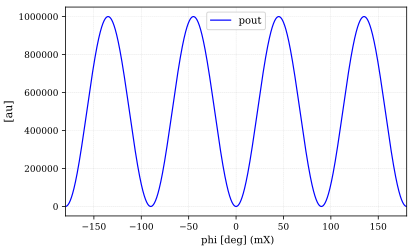

In [118]:
kat2 = deepcopy(kat1)
# changing mX is pointless given xaxis, instead change mY and be sure to use put*
kat2.mY.phi = 90

out2 = kat2.run()
out2.plot()

In [109]:
import scipy.optimize as opt
help(opt.minimize_scalar)

Help on function minimize_scalar in module scipy.optimize._minimize:

minimize_scalar(fun, bracket=None, bounds=None, args=(), method='brent', tol=None, options=None)
    Minimization of scalar function of one variable.
    
    Parameters
    ----------
    fun : callable
        Objective function.
        Scalar function, must return a scalar.
    bracket : sequence, optional
        For methods 'brent' and 'golden', `bracket` defines the bracketing
        interval and can either have three items ``(a, b, c)`` so that
        ``a < b < c`` and ``fun(b) < fun(a), fun(c)`` or two items ``a`` and
        ``c`` which are assumed to be a starting interval for a downhill
        bracket search (see `bracket`); it doesn't always mean that the
        obtained solution will satisfy ``a <= x <= c``.
    bounds : sequence, optional
        For method 'bounded', `bounds` is mandatory and must have two items
        corresponding to the optimization bounds.
    args : tuple, optional
        E

In [113]:
# why not larger than 10mW?
kat3 = deepcopy(kat2)
code = """
noxaxis
"""
kat3.parse(code)
out3 = kat3.run()

--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:37:56.102085
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0120695 seconds


100% | ETA:  0:00:00 | Calculating                                             

In [115]:
# out3.y gives abs at darkport

array([[3.74939946e-27]])

In [164]:
def darkport(phi):
    kat = deepcopy(kat2)
    kat.noxaxis = True
    kat.mY.phi = phi
    out = kat.run()
    return out.y[0][0]

In [165]:
dp10m = lambda x : darkport(x) - 10e-3

In [166]:
val10m = opt.bisect(dp10m, 0, 90)

--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:29.849426
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0107324 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:29.870404
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0130188 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:29.891524
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00904822 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:29.905956
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00905061 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:29.920873
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finess

100% | ETA:  0:00:00 | Calculating                                             

--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.053402
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0116525 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.075510
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0119455 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.094164
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00975442 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.109235
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00922775 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.124101
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finess

100% | ETA:  0:00:00 | Calculating                                             

--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.256973
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0108662 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.274132
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0106268 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.291321
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0142968 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.310897
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00897455 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.325566
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse

100% | ETA:  0:00:00 | Calculating                                             

--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.464630
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0124457 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.483524
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.011831 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.502223
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00929523 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.516910
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00910401 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.531508
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse

100% | ETA:  0:00:00 | Calculating                                             

In [167]:
darkport(val10m)

--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:55:30.631052
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0121062 seconds


100% | ETA:  0:00:00 | Calculating                                             

0.00999999999785177

In [178]:
kat3c = deepcopy(kat3)
kat3c.mY.phi = val10m
out3c = kat3c.run()
print('Pout = {0} mW'.format(1000.0*out3c['pout']))

--------------------------------------------------------------
Running kat - Started at 2020-07-22 16:56:43.432039
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0110686 seconds
Pout = 9.99999999785177 mW


100% | ETA:  0:00:00 | Calculating                                             

In [181]:
ifobasekat.components

{'BS': <pykat.components.beamSplitter_389 (BS) at 0x7f219c122c18>,
 'LX': <pykat.components.space_390 (LX) at 0x7f219e68a0f0>,
 'LY': <pykat.components.space_392 (LY) at 0x7f219c0ff518>,
 'laser': <pykat.components.laser_387 (laser) at 0x7f219c093390>,
 'mX': <pykat.components.mirror_391 (mX) at 0x7f219e70d0b8>,
 'mY': <pykat.components.mirror_393 (mY) at 0x7f219c0ff438>,
 's1': <pykat.components.space_388 (s1) at 0x7f219e68a5f8>,
 'sout': <pykat.components.space_394 (sout) at 0x7f219c5b5ac8>}

--------------------------------------------------------------
Running kat - Started at 2020-07-22 17:17:05.142698
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0308182 seconds


100% | ETA:  0:00:00 | Calculating                                             

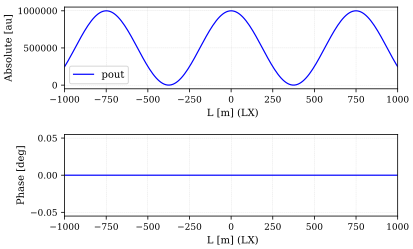

In [218]:
# differential length
kat4 = deepcopy(ifobasekat)
kat4.laser.f = 1e5
code = """
xaxis* LX L lin -1k 1k 200  # * avoids -ve lengths
func yshift = 4000 + $mx1
put* LY L $yshift
noplot yshift
yaxis abs:deg
"""
kat4.parse(code)
out4 = kat4.run()
out4.plot()

In [ ]:
# import pykat as pk
# %matplotlib inline

# kat = pk.finesse.kat()
# kat.load('cavity1.kat')
# print(kat.components,kat.detectors,kat.commands)
# print(kat.components['i1'])
# kat.m2.R = 0.9
# kat.m2.T = 0.1

# code = """
# l laser 1 0 n1
# s space 1 n1 n2
# pd pout n2
# xaxis laser P lin 1 10 100
# """

# kat.parse(code)

# out = kat.run()
# out.plot()